In [ ]:
!pip3 install 

In [36]:
from pygln import GLN
# %cd aiagentarch
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.ppo import MlpPolicy


import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm,trange
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader

import import_ipynb

import time
from aiagentarch.cartpole_tasks import CartPoleEnv
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [8]:
def expert_reward(env,expert):
    obs = env.reset()
    for i in range(1000):
        action, _state = expert.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        if done: break
    return i


def net_reward(env,net):
    obs = env.reset()
    for i in range(1000):
        action = net.predict(obs.reshape(1,-1)).item()
        obs, reward, done, info = env.step(action)
        if done: break
    return i


def rollout(env,expert,max_episodes=1000,max_timesteps=1):
    obs_list,act_list = [],[]
    timestep =0
    for i in range(max_episodes):
        obs = env.reset()
        for j in range(1000):
            action, _state = expert.predict(obs, deterministic=True)
            obs_list.append(obs)
            act_list.append(action.item())
            obs, reward, done, info = env.step(action)
            timestep+=1
            if timestep>=max_timesteps:
                return torch.tensor(obs_list),torch.tensor(act_list)
            
            if done: break
    
    return torch.tensor(obs_list),torch.tensor(act_list)
        


In [9]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [275]:
rng = np.random.default_rng(0)
env = CartPoleEnv()
expert = PPO(policy=MlpPolicy, env=env)
expert.learn(total_timesteps=5000)

In [276]:
print("Expert Reward:",expert_reward(env,expert))

Expert Reward: 774


In [277]:
#Transitions has obs and actions
transitions = rollout(env,expert,max_timesteps=5000)
obs,acts = transitions
obs,acts = obs.to(device),acts.to(device)
acts_neg = 1 - acts

# Forward Forward

In [278]:
def overlay_y_on_x(obs,label):
    if type(label)==int:
        acts = torch.tensor([label for i in range(obs.shape[0])])
    
    else:
        acts=label
    obs = torch.tensor(obs).to(device)
    acts = torch.tensor(acts).to(device)

    return torch.cat([obs,acts.view(-1,1)],axis=1)

In [279]:
obs_pos = overlay_y_on_x(obs,acts)
obs_neg = overlay_y_on_x(obs,acts_neg)

In [15]:
# class Net(torch.nn.Module):

#     def __init__(self, dims):
#         super().__init__()
#         self.layers = []
#         for d in range(len(dims) - 1):
#             self.layers += [Layer(dims[d], dims[d + 1]).to(device)]

#     def predict(self, x):
#         goodness_per_label = []
#         for label in range(2):
#             h = overlay_y_on_x(x, label)
#             goodness = []
#             for layer in self.layers:
#                 h = layer(h)
#                 goodness += [h.pow(2).mean(1)]
#             goodness_per_label += [sum(goodness).unsqueeze(1)]
#         goodness_per_label = torch.cat(goodness_per_label, 1)
#         return goodness_per_label.argmax(1)

#     def train(self, x_pos, x_neg):
#         h_pos, h_neg = x_pos, x_neg
#         for i, layer in enumerate(self.layers):
#             print('training layer', i+1, '...')
#             h_pos, h_neg = layer.train(h_pos, h_neg)


# class Layer(nn.Linear):
#     def __init__(self, in_features, out_features,
#                  bias=True, device=None, dtype=None):
#         super().__init__(in_features, out_features, bias, device, dtype)
#         self.relu = torch.nn.ReLU()
#         self.opt = Adam(self.parameters(), lr=0.03)
#         self.threshold = 2.0
#         self.num_epochs = 1000

#     def forward(self, x):
#         x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
#         return self.relu(
#             torch.mm(x_direction, self.weight.T) +
#             self.bias.unsqueeze(0))

#     def train(self, x_pos, x_neg):
#         for i in tqdm(range(self.num_epochs)):
#             g_pos = self.forward(x_pos).pow(2).mean(1)
#             g_neg = self.forward(x_neg).pow(2).mean(1)
#             # The following loss pushes pos (neg) samples to
#             # values larger (smaller) than the self.threshold.
#             loss = torch.log(1 + torch.exp(torch.cat([
#                 -g_pos + self.threshold,
#                 g_neg - self.threshold]))).mean()
#             self.opt.zero_grad()
#             # this backward just compute the derivative and hence
#             # is not considered backpropagation.
#             loss.backward()
#             self.opt.step()
#         return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [283]:
class FFLayer(nn.Linear):
    def __init__(self,in_features,out_features):
        super().__init__(in_features,out_features,bias=True)
        self.lr = 0.05
        self.optimizer = torch.optim.Adam(self.parameters(),lr=self.lr)
        self.n_epochs = 1000
        self.relu=nn.ReLU()
        self.threshold = 2


    def forward(self,x):
        x_dir = x/x.norm(2,1,keepdim=True)
        return self.relu(super().forward(x_dir))
    
    def train(self,x_pos,x_neg):
        x_pos=x_pos.to(device)
        x_neg=x_neg.to(device)
        for i in tqdm(range(self.n_epochs)):
            goodness_pos = self(x_pos).pow(2).mean(1)   #Mean of sum of squares of the samples (Mean can be ommitted)
            goodness_neg = self(x_neg).pow(2).mean(1)   
            loss = torch.log(1 + torch.exp(torch.cat([-goodness_pos+self.threshold,goodness_neg-self.threshold]))).mean()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        return self(x_pos).detach(),self(x_neg).detach()



class FFNet(nn.Module):
    def __init__(self,dims):
        self.layers = []
        for i,j in zip(dims[:-1],dims[1:]):
            self.layers.append(FFLayer(i,j).to(device))
    
    def train(self,x_pos,x_neg):
        for i,layer in enumerate(self.layers):
            print(f"Training Layer:{i+1}")
            x_pos,x_neg = layer.train(x_pos,x_neg)

    def predict(self,x_):
        goodness_per_label = []
        for label in range(2):
            x = overlay_y_on_x(x_,label)
            goodness=0
            for layer in self.layers:
                x = layer(x)
                goodness+= x.pow(2).mean(1)
            goodness_per_label.append(goodness)
        
        goodness_per_label = torch.stack(goodness_per_label,axis=1)
        predictions = goodness_per_label.argmax(1)
        return predictions


In [284]:
net = FFNet([5, 200, 200])
net.train(obs_pos,obs_neg)

Training Layer:1


100%|██████████| 1000/1000 [00:03<00:00, 258.72it/s]


Training Layer:2


100%|██████████| 1000/1000 [00:05<00:00, 180.88it/s]


In [285]:
net_reward(env,net)

999

In [18]:
import pickle
with open('aiagentarch/perf.pickle','rb') as f: perf = pickle.load(f)

In [19]:
print(perf)

{10: {0.5: 999.0, 0.75: 999.0, 1.0: 999.0, 1.25: 999.0, 1.5: 999.0, 1.75: 999.0, 2.0: 999.0, 2.25: 999.0, 2.5: 999.0, 2.75: 999.0, 3.0: 999.0, 3.25: 682.3333333333334, 3.5: 674.0, 3.75: 25.666666666666668, 4.0: 25.0, 4.25: 26.0, 4.5: 26.666666666666668, 4.75: 27.333333333333332, 5.0: 27.666666666666668, 5.25: 27.666666666666668}, 20: {0.5: 999.0, 0.75: 999.0, 1.0: 999.0, 1.25: 999.0, 1.5: 999.0, 1.75: 999.0, 2.0: 999.0, 2.25: 999.0, 2.5: 999.0, 2.75: 999.0, 3.0: 682.3333333333334, 3.25: 683.0, 3.5: 349.0, 3.75: 32.666666666666664, 4.0: 24.666666666666668, 4.25: 25.666666666666668, 4.5: 26.0, 4.75: 27.666666666666668, 5.0: 26.333333333333332, 5.25: 27.0}, 30: {0.5: 999.0, 0.75: 999.0, 1.0: 999.0, 1.25: 999.0, 1.5: 999.0, 1.75: 999.0, 2.0: 999.0, 2.25: 999.0, 2.5: 999.0, 2.75: 689.0, 3.0: 682.6666666666666, 3.25: 39.0, 3.5: 36.0, 3.75: 37.666666666666664, 4.0: 24.666666666666668, 4.25: 26.0, 4.5: 25.333333333333332, 4.75: 26.0, 5.0: 29.666666666666668, 5.25: 28.666666666666668}, 40: {0.5

In [20]:
gravity = list(perf.keys())[::2]
length = list(perf[gravity[0]].keys())[::2]
print("Gravity :",gravity,"\nLength :",length)

Gravity : [10, 30, 50, 70, 90, 110, 130, 150, 170, 190] 
Length : [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [21]:
import random
#all permutations of gravity and length as a list of tuples
settings = [(g,l) for g in gravity for l in length]
rng.shuffle(settings)
train_tasks,test_tasks = 20,10
train_settings = settings[:train_tasks]
test_settings = settings[train_tasks:train_tasks+test_tasks]

# train_settings = [(g,l) for g in gravity[:5] for l in length[:5]]
# rng.shuffle(train_settings)
# test_settings = [(g,l) for g in gravity[5:] for l in length[5:]]
# rng.shuffle(test_settings)

# Heatmap of RL performance on cartpole for varying gravity and length - Baseline

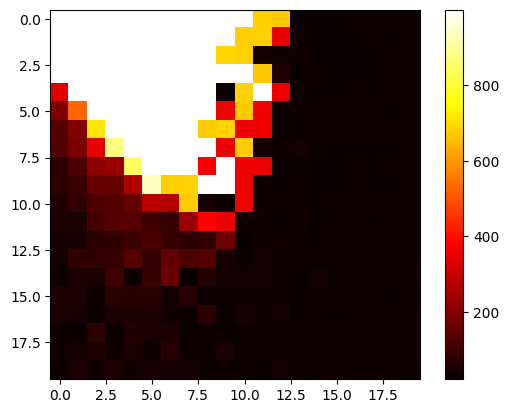

In [22]:
h=np.zeros((20,20))
i,j=0,0
for g in range(10,210,10):
    j=0
    for l4 in range(2,22):
        h[i][j]=perf[g][l4/4]
        # print(i,j,g,l4/4,perf[g][l4/4])
        j+=1
    i+=1

plt.imshow(h, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [67]:

def train(env,expert,net):
    expert.set_env(env)
    expert.learn(total_timesteps=5000)
    rew = expert_reward(env,expert)
    print("Expert Reward:",rew)

    transitions = rollout(env,expert,max_timesteps=5000)
    obs,acts = transitions
    obs,acts = obs.to(device),acts.to(device)
    acts_neg = (1 - acts).detach()

    obs_pos = overlay_y_on_x(obs,acts)
    obs_neg = overlay_y_on_x(obs,acts_neg)

    net.train(obs_pos,obs_neg)
    rew = net_reward(env,net)
    print("FF Reward",rew)
    return rew


def adapt(env,expert,net):
    rew = expert_reward(env,expert)
    print("Expert Reward:",rew)

    transitions = rollout(env,expert,max_episodes=1)
    obs,acts = transitions
    obs,acts = obs.to(device),acts.to(device)
    acts_neg = (1 - acts).detach()

    obs_pos = overlay_y_on_x(obs,acts)
    obs_neg = overlay_y_on_x(obs,acts_neg)
    net.train(obs_pos,obs_neg)
    rew = net_reward(env,net)
    print("FF Reward",rew)
    return rew

    

In [57]:
FF_perf = {g:{l:0 for l in length} for g in gravity}

In [58]:
expert = PPO(policy=MlpPolicy, env=env)
net = FFNet([5, 200, 200])

#Training
print("Training:\n")
i=1
for g,l in train_settings:
    print(f"{i}. Gravity: {g}, Length: {l}")
    env.length , env.gravity = l , g
    env.polemass_length = env.masspole * env.length
    FF_perf[g][l]=train(env,expert,net)
    print()
    i+=1

Training:

1. Gravity: 170, Length: 1.5
Expert Reward: 37
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 238.40it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:06<00:00, 145.80it/s]


FF Reward 27

2. Gravity: 70, Length: 3.5
Expert Reward: 179
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 213.93it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:06<00:00, 158.12it/s]


FF Reward 60

3. Gravity: 50, Length: 0.5
Expert Reward: 159
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 240.66it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 170.38it/s]


FF Reward 234

4. Gravity: 10, Length: 3.0
Expert Reward: 196
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 241.24it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 169.96it/s]


FF Reward 154

5. Gravity: 190, Length: 2.0
Expert Reward: 66
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 242.26it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 171.58it/s]


FF Reward 78

6. Gravity: 30, Length: 3.5
Expert Reward: 160
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 225.08it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:06<00:00, 163.46it/s]


FF Reward 77

7. Gravity: 190, Length: 2.5
Expert Reward: 37
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 230.98it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 171.22it/s]


FF Reward 175

8. Gravity: 110, Length: 1.5
Expert Reward: 149
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 242.57it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 171.52it/s]


FF Reward 121

9. Gravity: 150, Length: 1.5
Expert Reward: 575
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 243.50it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 169.38it/s]


FF Reward 117

10. Gravity: 190, Length: 0.5
Expert Reward: 17
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 242.84it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 169.49it/s]


FF Reward 40

11. Gravity: 170, Length: 2.0
Expert Reward: 59
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 242.41it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 171.56it/s]


FF Reward 103

12. Gravity: 30, Length: 2.0
Expert Reward: 747
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 241.87it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 168.46it/s]


FF Reward 90

13. Gravity: 170, Length: 1.0
Expert Reward: 167
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 236.27it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 170.82it/s]


FF Reward 133

14. Gravity: 70, Length: 4.0
Expert Reward: 197
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 241.40it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 171.13it/s]


FF Reward 168

15. Gravity: 30, Length: 1.0
Expert Reward: 448
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 241.61it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 167.17it/s]


FF Reward 120

16. Gravity: 30, Length: 0.5
Expert Reward: 999
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 221.66it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 170.77it/s]


FF Reward 333

17. Gravity: 150, Length: 3.0
Expert Reward: 999
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 240.81it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 170.99it/s]


FF Reward 198

18. Gravity: 10, Length: 4.5
Expert Reward: 745
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 240.92it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 170.62it/s]


FF Reward 999

19. Gravity: 50, Length: 4.0
Expert Reward: 999
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 241.89it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 170.87it/s]


FF Reward 999

20. Gravity: 10, Length: 5.0
Expert Reward: 999
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 241.77it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 170.91it/s]


FF Reward 237



In [68]:

print("Testing:")
i=1
for g,l in settings[3:]:
    print(f"{i}. Gravity: {g}, Length: {l}")
    env.length , env.gravity = l , g
    env.polemass_length = env.masspole * env.length
    FF_perf[g][l] = adapt(env,expert,net)
    print()
    i+=1

Testing:
1. Gravity: 10, Length: 3.0
Expert Reward: 686
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 233.03it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 171.04it/s]


FF Reward 357

2. Gravity: 190, Length: 2.0
Expert Reward: 999
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 243.01it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 172.70it/s]


FF Reward 28

3. Gravity: 30, Length: 3.5
Expert Reward: 495
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 241.98it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 171.80it/s]


FF Reward 279

4. Gravity: 190, Length: 2.5
Expert Reward: 65
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 242.71it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:05<00:00, 172.32it/s]


FF Reward 327

5. Gravity: 110, Length: 1.5
Expert Reward: 999
training layer 0 ...


100%|██████████| 1000/1000 [00:04<00:00, 231.93it/s]


training layer 1 ...


 31%|███       | 306/1000 [00:01<00:04, 162.30it/s]


KeyboardInterrupt: 

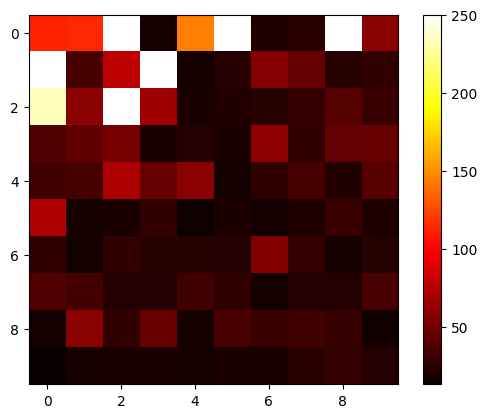

In [64]:
h=np.zeros((10,10))
i,j=0,0
for g in gravity:
    j=0
    for l in length:
        h[i][j]=FF_perf[g][l]
        j+=1
    i+=1

h_ = np.where(h>250,250,h)

plt.imshow(h_, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

## GLN

Expert Reward: 88


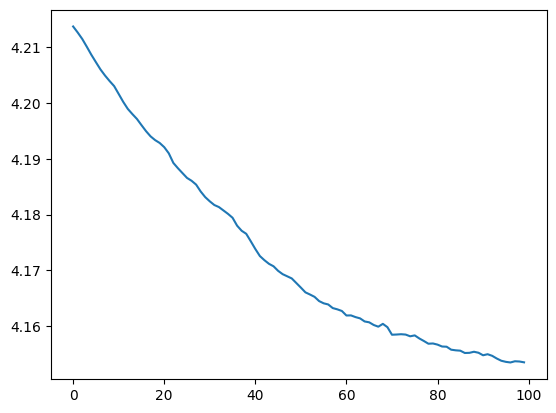

In [242]:
env.length , env.gravity = 1.5 , 50
env.polemass_length = env.masspole * env.length
expert = PPO(policy=MlpPolicy, env=env)
expert.learn(total_timesteps=10000)
rew = expert_reward(env,expert)
print("Expert Reward:",rew)
transitions = rollout(env,expert,max_timesteps=5000)
obs,acts = transitions
gln = GLN(backend='pytorch',layer_sizes=[16,8,1],input_size=4)
obs_= obs.cpu().numpy()
acts_= acts.cpu().numpy()
loss = nn.CrossEntropyLoss(reduction='sum')
losses = []
fas = 100
for i in range(fas):
    preds =gln.predict(obs_,acts_,return_probs=True)
    l= loss(torch.Tensor(preds),torch.Tensor(acts_)).item()/len(acts_)
    losses.append(l)

plt.plot(losses)

fas of around 40 steps with default learning rate <br>
fas of around 10 steps is sufficient with learning rate >=0.05

In [270]:
def gln_reward(env,gln):
    obs = env.reset()
    for i in range(1000):
        action = gln.predict(obs.reshape(1,-1)).astype(int)[0]
        obs, reward, done, info = env.step(action)
        if done: break
    return i



def GLN_train(env,expert,gln):
    expert.set_env(env)
    expert.learn(total_timesteps=10000)
    rew = expert_reward(env,expert)
    print("Expert Reward:",rew)

    transitions = rollout(env,expert,max_timesteps=5000)
    obs,acts = transitions
    obs,acts = obs.cpu().numpy(),acts.cpu().numpy()
    loss = nn.CrossEntropyLoss(reduction='sum')
    losses = []
    
    fas =40
    for i in range(fas):
        preds =gln.predict(obs_,acts_,return_probs=True)
        l= loss(torch.Tensor(preds),torch.Tensor(acts_)).item()/len(acts_)
        losses.append(l)
    plt.figure(figsize=(6,3))
    plt.plot(losses)
    plt.show()

    rew = gln_reward(env,gln)
    print("GLN Reward",rew)
    return rew


def GLN_adapt(env,expert,net):
    rew = expert_reward(env,expert)
    print("Expert Reward:",rew)

    transitions = rollout(env,expert,max_episodes=1)
    obs,acts = transitions
    obs,acts = obs.cpu().numpy(),acts.cpu().numpy()
    loss = nn.CrossEntropyLoss(reduction='sum')
    losses = []
    
    fas =40
    for i in range(fas):
        preds =gln.predict(obs_,acts_,return_probs=True)
        l= loss(torch.Tensor(preds),torch.Tensor(acts_)).item()/len(acts_)
        losses.append(l)
    plt.figure(figsize=(6,3))
    plt.plot(losses)
    plt.show()

    rew = gln_reward(env,gln)
    print("GLN Reward",rew)
    return rew
    

In [257]:
GLN_perf = {g:{l:0 for l in length} for g in gravity}

Training:

1. Gravity: 170, Length: 1.5
Expert Reward: 91


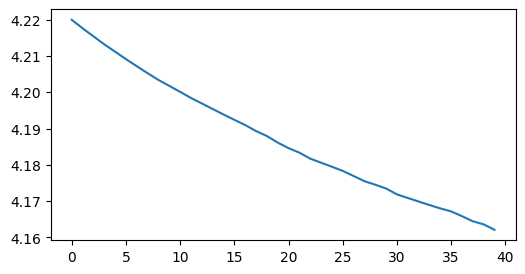

GLN Reward 23

2. Gravity: 70, Length: 3.5
Expert Reward: 217


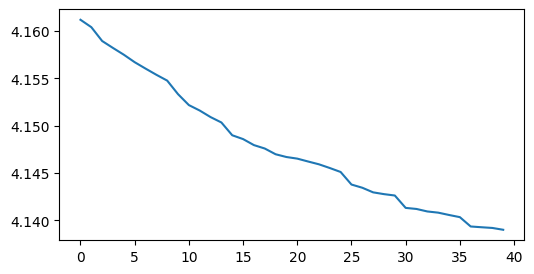

GLN Reward 36

3. Gravity: 50, Length: 0.5
Expert Reward: 175


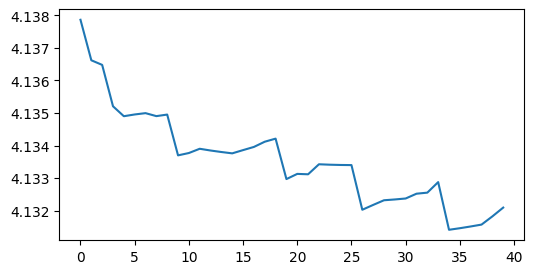

GLN Reward 47

4. Gravity: 10, Length: 3.0
Expert Reward: 269


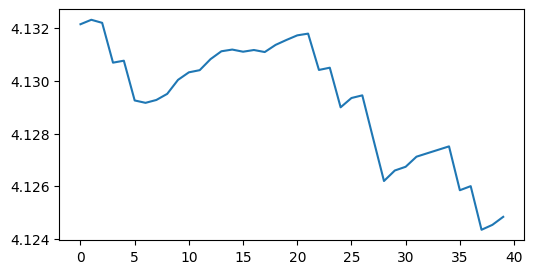

GLN Reward 139

5. Gravity: 190, Length: 2.0
Expert Reward: 128


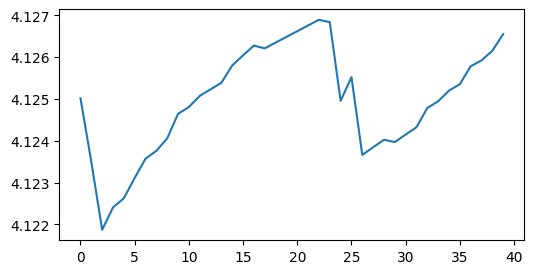

GLN Reward 20

6. Gravity: 30, Length: 3.5
Expert Reward: 999


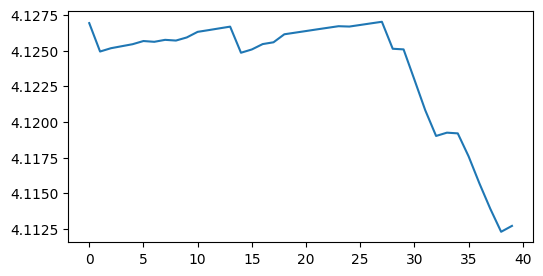

GLN Reward 117

7. Gravity: 190, Length: 2.5
Expert Reward: 60


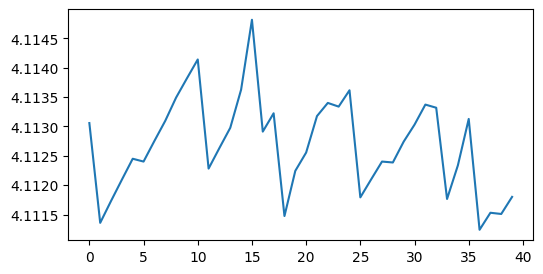

GLN Reward 52

8. Gravity: 110, Length: 1.5
Expert Reward: 999


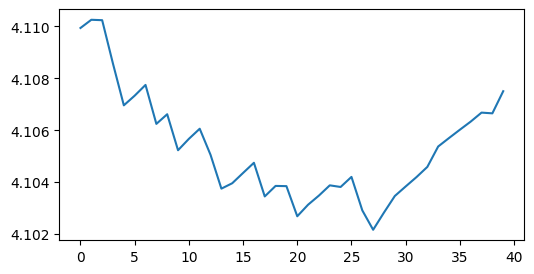

GLN Reward 74

9. Gravity: 150, Length: 1.5
Expert Reward: 612


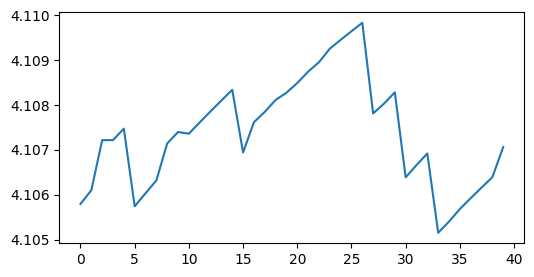

GLN Reward 27

10. Gravity: 190, Length: 0.5
Expert Reward: 21


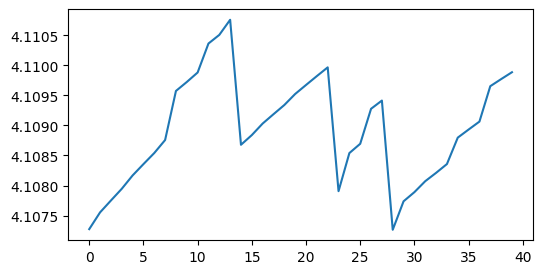

GLN Reward 14

11. Gravity: 170, Length: 2.0
Expert Reward: 999


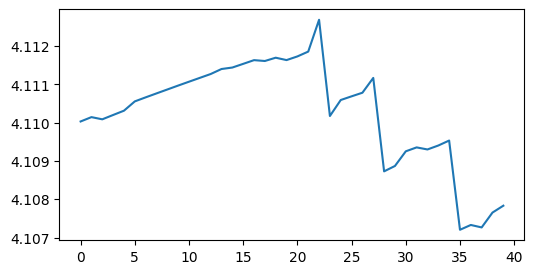

GLN Reward 31

12. Gravity: 30, Length: 2.0
Expert Reward: 999


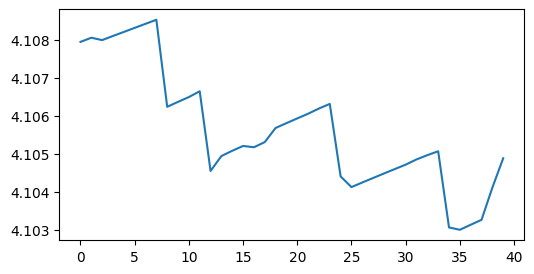

GLN Reward 157

13. Gravity: 170, Length: 1.0
Expert Reward: 499


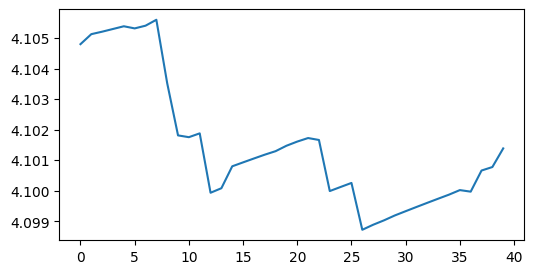

GLN Reward 15

14. Gravity: 70, Length: 4.0
Expert Reward: 999


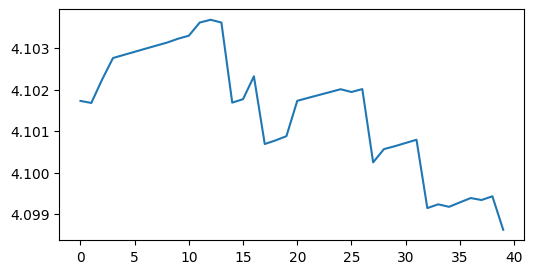

GLN Reward 71

15. Gravity: 30, Length: 1.0
Expert Reward: 999


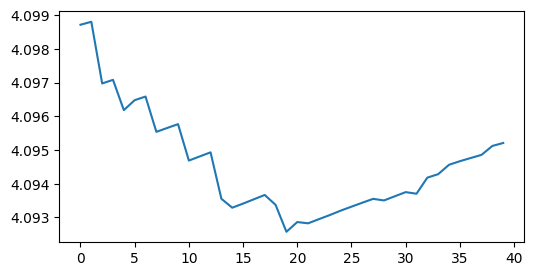

GLN Reward 78

16. Gravity: 30, Length: 0.5
Expert Reward: 999


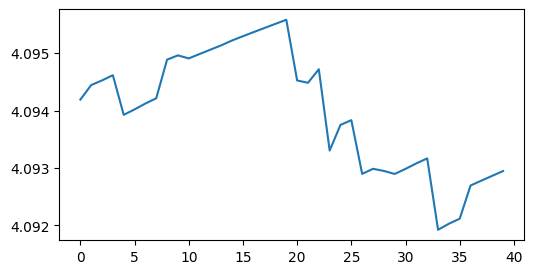

GLN Reward 54

17. Gravity: 150, Length: 3.0
Expert Reward: 25


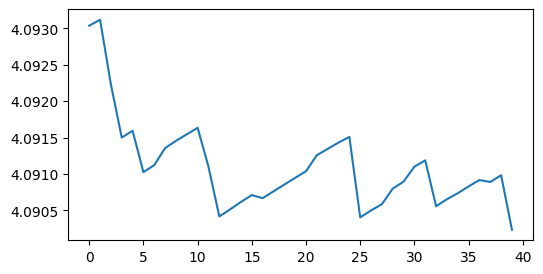

GLN Reward 47

18. Gravity: 10, Length: 4.5
Expert Reward: 30


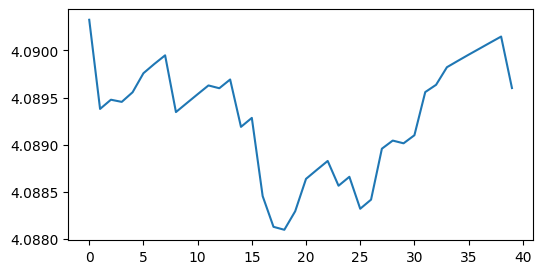

GLN Reward 146

19. Gravity: 50, Length: 4.0
Expert Reward: 62


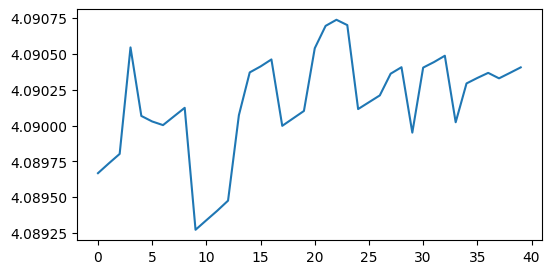

GLN Reward 119

20. Gravity: 10, Length: 5.0
Expert Reward: 71


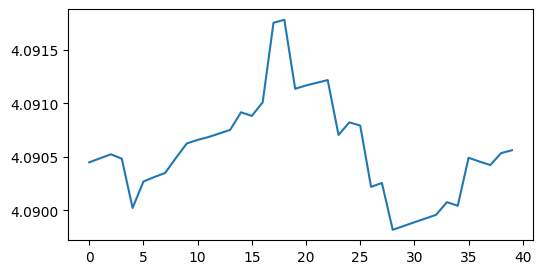

GLN Reward 118



In [261]:
expert = PPO(policy=MlpPolicy, env=env)
gln = GLN(backend='pytorch',layer_sizes=[32,16,1],input_size=4)

#Training
print("Training:\n")
i=1
for g,l in train_settings:
    print(f"{i}. Gravity: {g}, Length: {l}")
    env.length , env.gravity = l , g
    env.polemass_length = env.masspole * env.length
    GLN_perf[g][l]=GLN_train(env,expert,gln)
    print()
    i+=1

Testing:
1. Gravity: 10, Length: 3.0
Expert Reward: 999


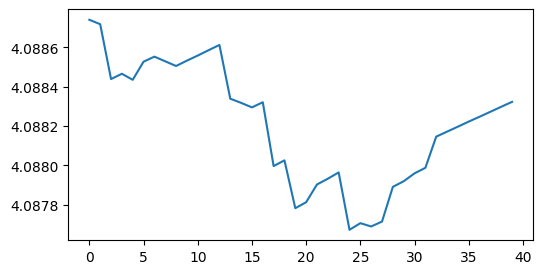

GLN Reward 150

2. Gravity: 190, Length: 2.0
Expert Reward: 999


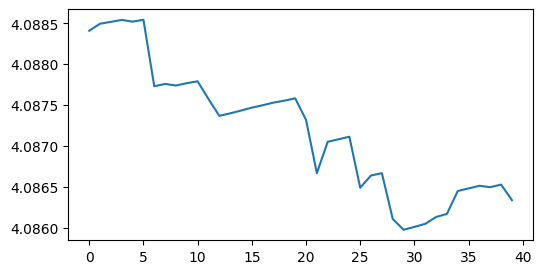

GLN Reward 20

3. Gravity: 30, Length: 3.5
Expert Reward: 67


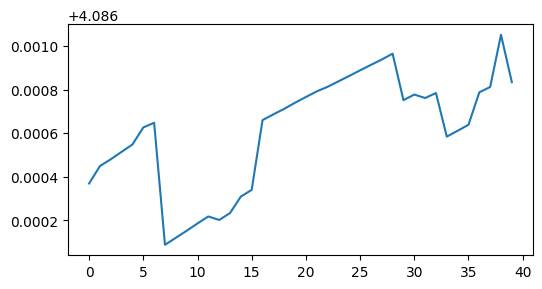

GLN Reward 90

4. Gravity: 190, Length: 2.5
Expert Reward: 28


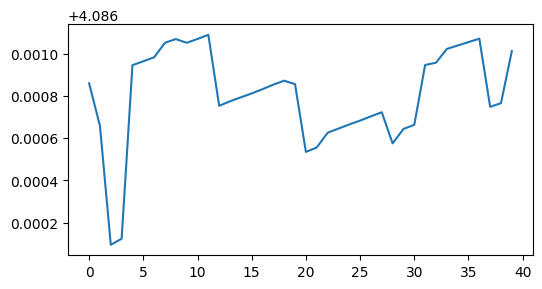

GLN Reward 29

5. Gravity: 110, Length: 1.5
Expert Reward: 999


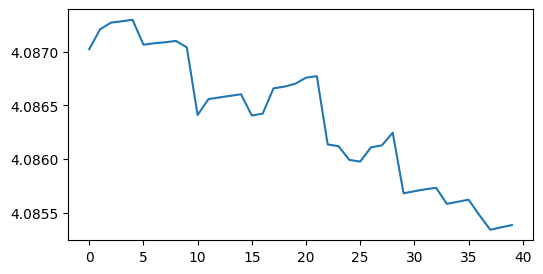

GLN Reward 36

6. Gravity: 150, Length: 1.5
Expert Reward: 999


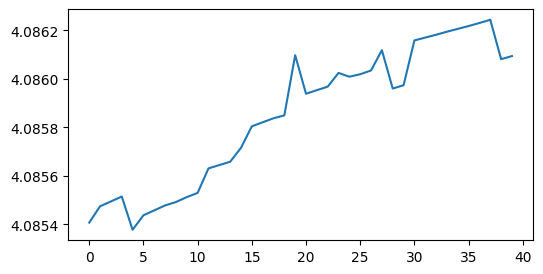

GLN Reward 30

7. Gravity: 190, Length: 0.5
Expert Reward: 24


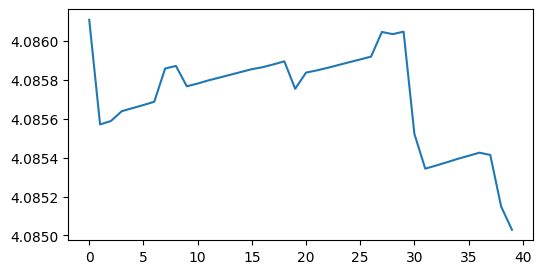

GLN Reward 11

8. Gravity: 170, Length: 2.0
Expert Reward: 999


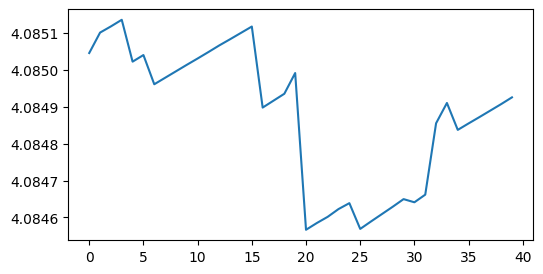

GLN Reward 33

9. Gravity: 30, Length: 2.0
Expert Reward: 999


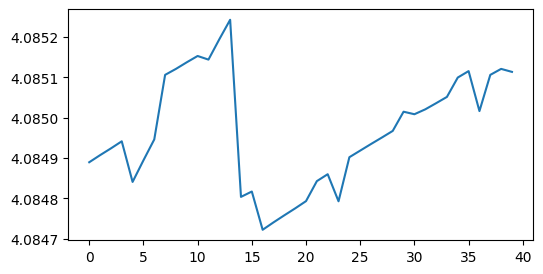

GLN Reward 201

10. Gravity: 170, Length: 1.0
Expert Reward: 999


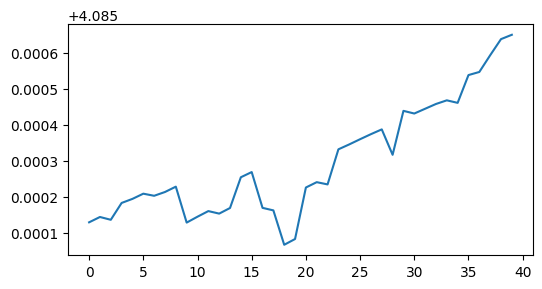

GLN Reward 62

11. Gravity: 70, Length: 4.0
Expert Reward: 62


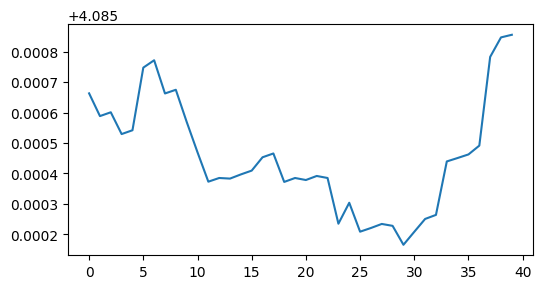

GLN Reward 50

12. Gravity: 30, Length: 1.0
Expert Reward: 999


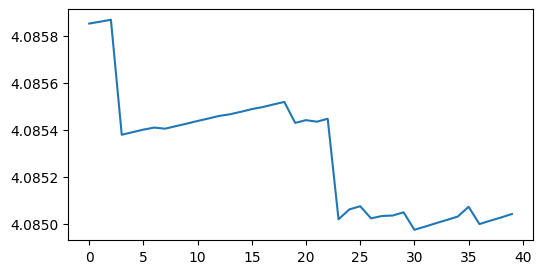

GLN Reward 59

13. Gravity: 30, Length: 0.5
Expert Reward: 999


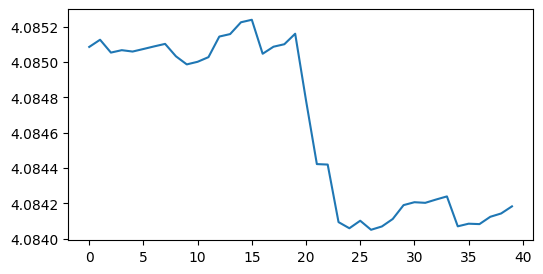

GLN Reward 86

14. Gravity: 150, Length: 3.0
Expert Reward: 34


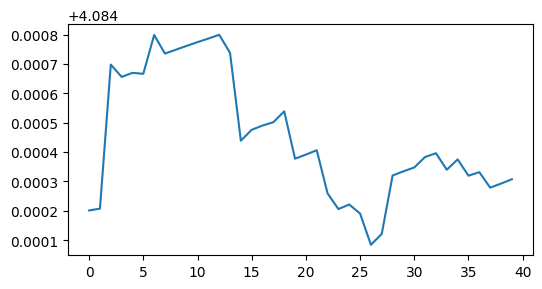

GLN Reward 37

15. Gravity: 10, Length: 4.5
Expert Reward: 65


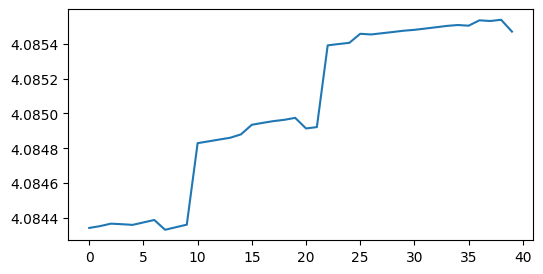

GLN Reward 132

16. Gravity: 50, Length: 4.0
Expert Reward: 52


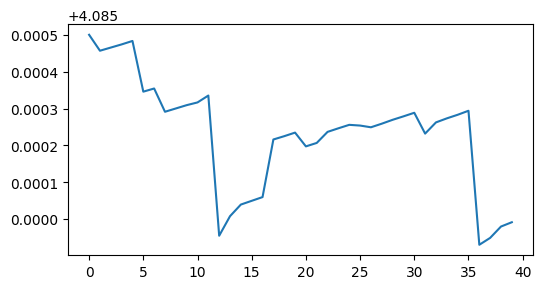

GLN Reward 71

17. Gravity: 10, Length: 5.0
Expert Reward: 80


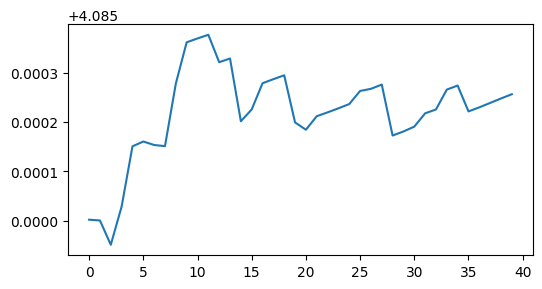

GLN Reward 137

18. Gravity: 190, Length: 4.0
Expert Reward: 33


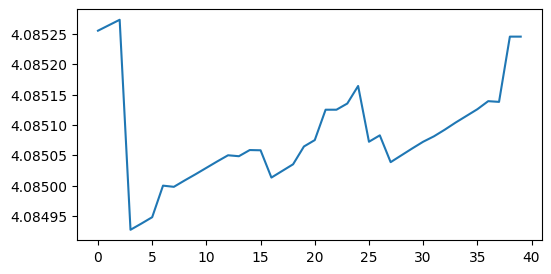

GLN Reward 41

19. Gravity: 50, Length: 2.0
Expert Reward: 999


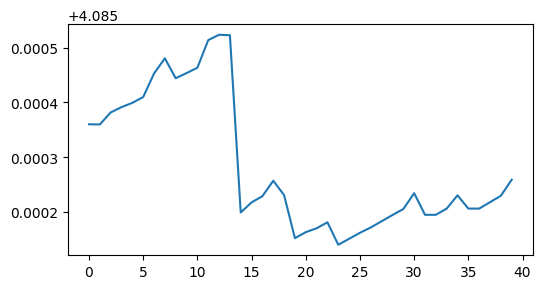

GLN Reward 99

20. Gravity: 50, Length: 1.5
Expert Reward: 999


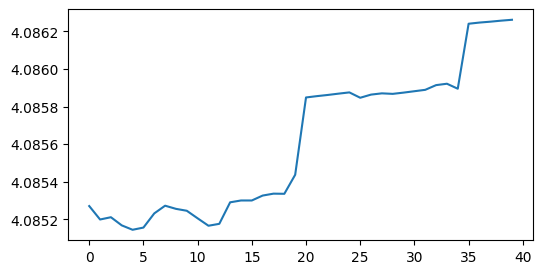

GLN Reward 51

21. Gravity: 30, Length: 5.0
Expert Reward: 69


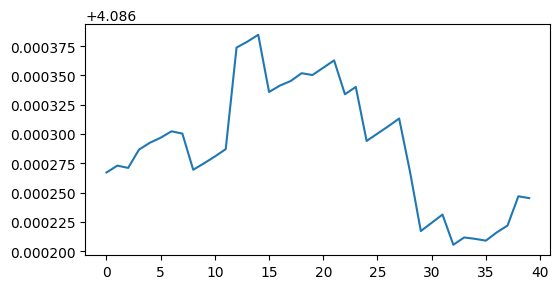

GLN Reward 93

22. Gravity: 110, Length: 0.5
Expert Reward: 999


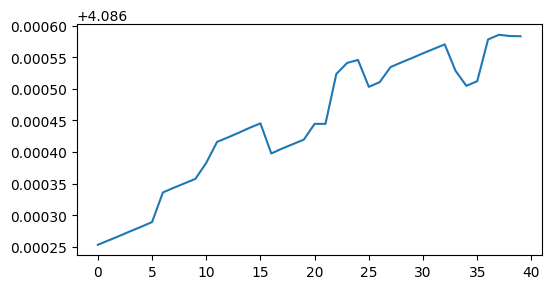

GLN Reward 19

23. Gravity: 190, Length: 4.5
Expert Reward: 28


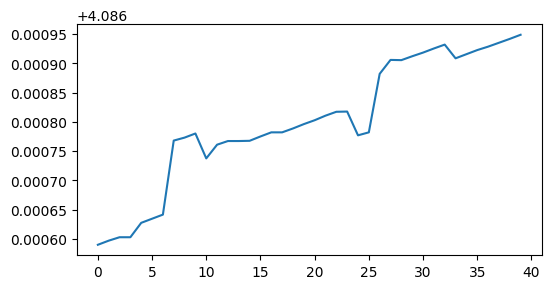

GLN Reward 70

24. Gravity: 170, Length: 3.0
Expert Reward: 29


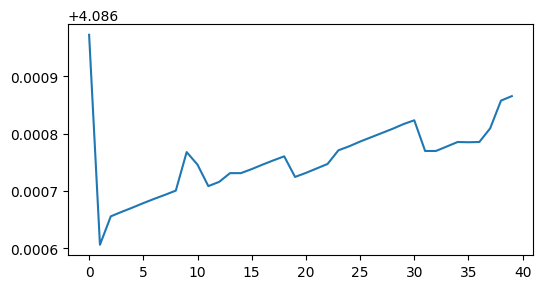

GLN Reward 84

25. Gravity: 90, Length: 2.5
Expert Reward: 999


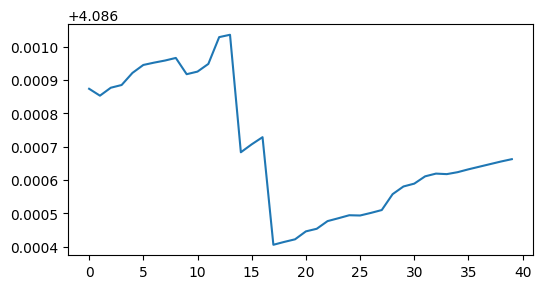

GLN Reward 65

26. Gravity: 150, Length: 1.0
Expert Reward: 999


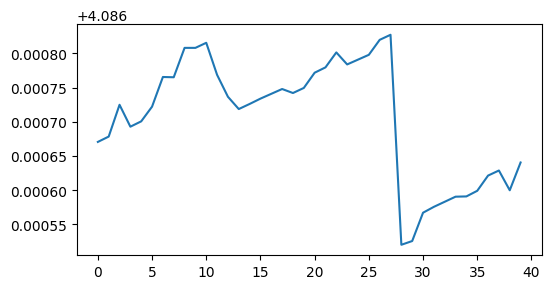

GLN Reward 21

27. Gravity: 10, Length: 2.5
Expert Reward: 999


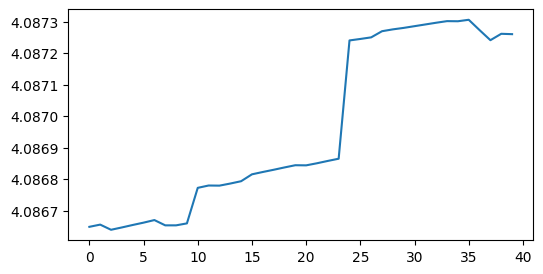

GLN Reward 142

28. Gravity: 50, Length: 3.0
Expert Reward: 124


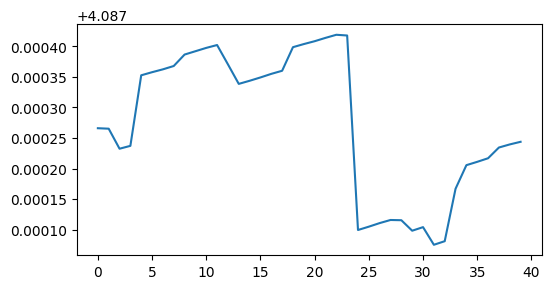

GLN Reward 60

29. Gravity: 150, Length: 0.5
Expert Reward: 106


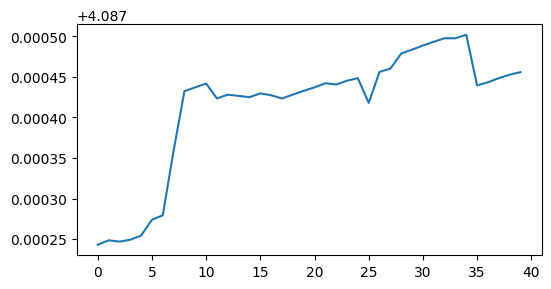

GLN Reward 19

30. Gravity: 70, Length: 2.5
Expert Reward: 98


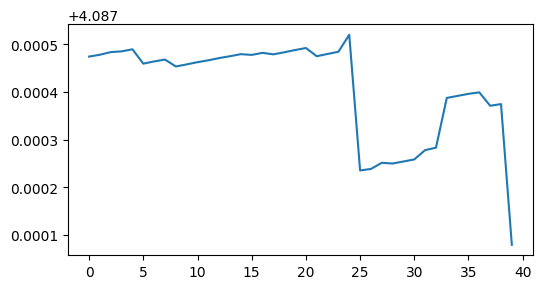

GLN Reward 46

31. Gravity: 70, Length: 5.0
Expert Reward: 32


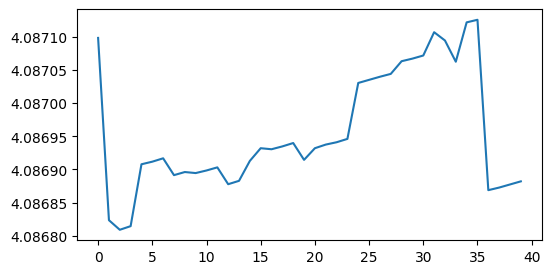

GLN Reward 109

32. Gravity: 130, Length: 2.5
Expert Reward: 59


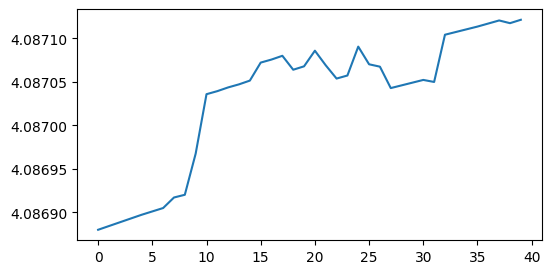

GLN Reward 44

33. Gravity: 110, Length: 4.0
Expert Reward: 31


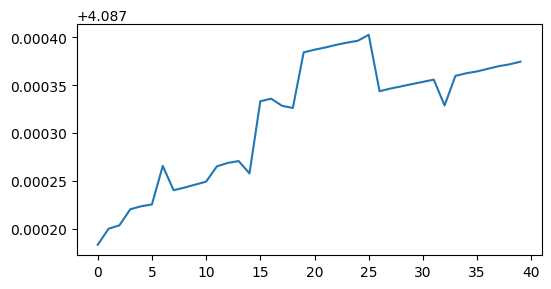

GLN Reward 55

34. Gravity: 130, Length: 3.0
Expert Reward: 57


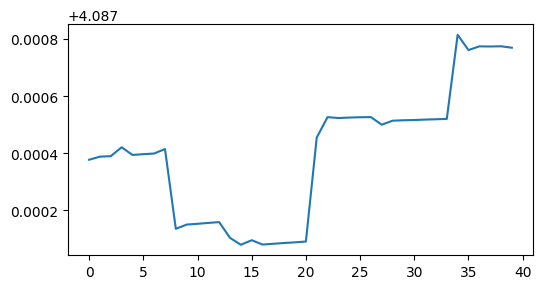

GLN Reward 37

35. Gravity: 90, Length: 1.5
Expert Reward: 999


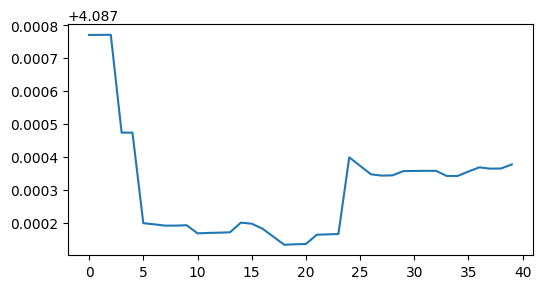

GLN Reward 39

36. Gravity: 130, Length: 3.5
Expert Reward: 36


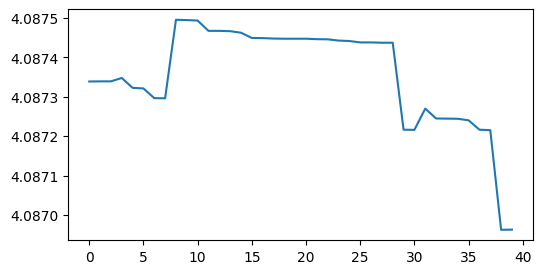

GLN Reward 34

37. Gravity: 30, Length: 3.0
Expert Reward: 122


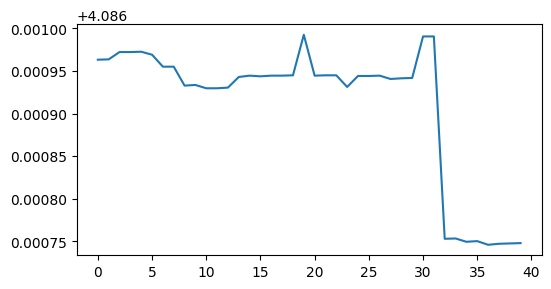

GLN Reward 107

38. Gravity: 70, Length: 0.5
Expert Reward: 999


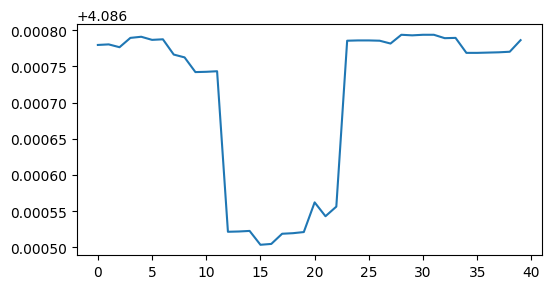

GLN Reward 32

39. Gravity: 10, Length: 1.5
Expert Reward: 999


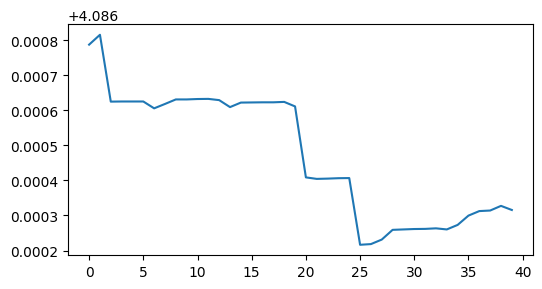

GLN Reward 336

40. Gravity: 70, Length: 3.0
Expert Reward: 64


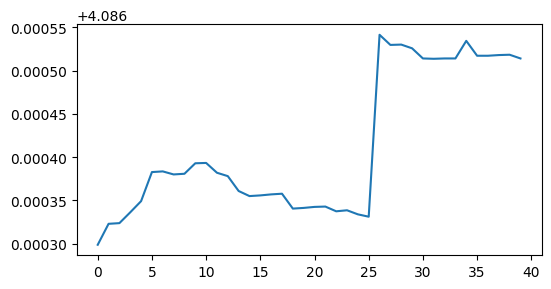

GLN Reward 77

41. Gravity: 170, Length: 3.5
Expert Reward: 37


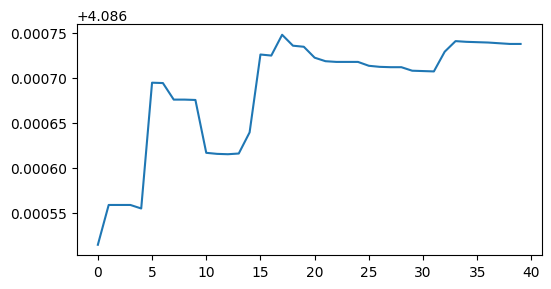

GLN Reward 30

42. Gravity: 90, Length: 2.0
Expert Reward: 999


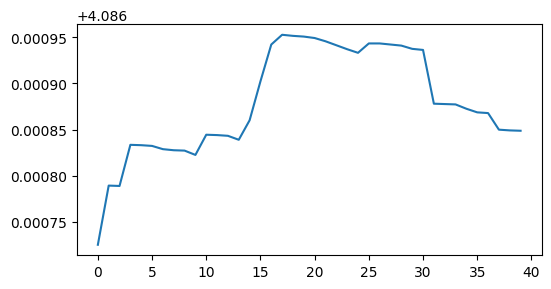

GLN Reward 30

43. Gravity: 30, Length: 4.0
Expert Reward: 58


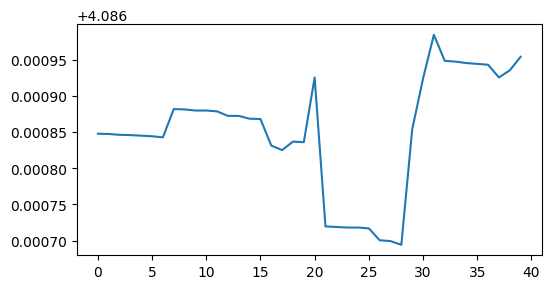

GLN Reward 91

44. Gravity: 150, Length: 2.5
Expert Reward: 28


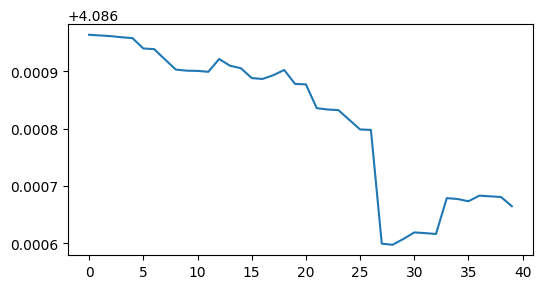

GLN Reward 41

45. Gravity: 50, Length: 4.5
Expert Reward: 63


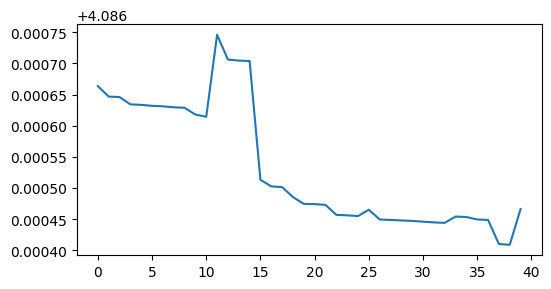

GLN Reward 77

46. Gravity: 170, Length: 4.0
Expert Reward: 32


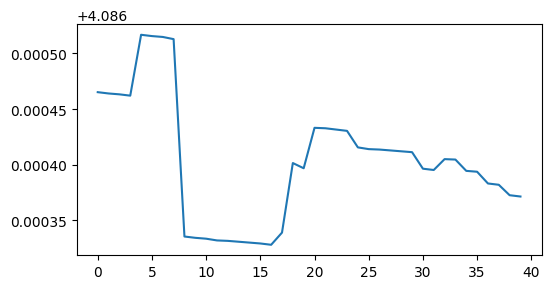

GLN Reward 31

47. Gravity: 30, Length: 4.5
Expert Reward: 69


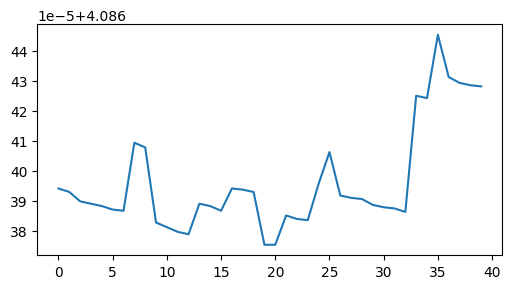

GLN Reward 118

48. Gravity: 170, Length: 0.5
Expert Reward: 76


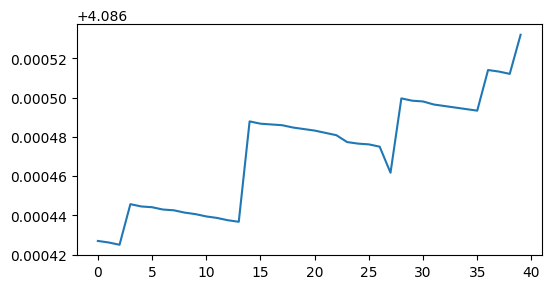

GLN Reward 17

49. Gravity: 10, Length: 2.0
Expert Reward: 999


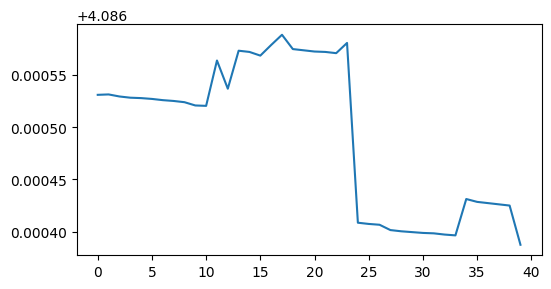

GLN Reward 475

50. Gravity: 10, Length: 1.0
Expert Reward: 999


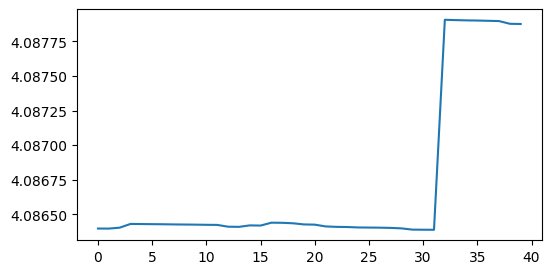

GLN Reward 409

51. Gravity: 110, Length: 3.0
Expert Reward: 60


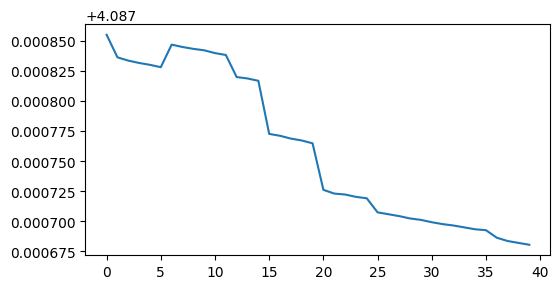

GLN Reward 33

52. Gravity: 110, Length: 2.0
Expert Reward: 999


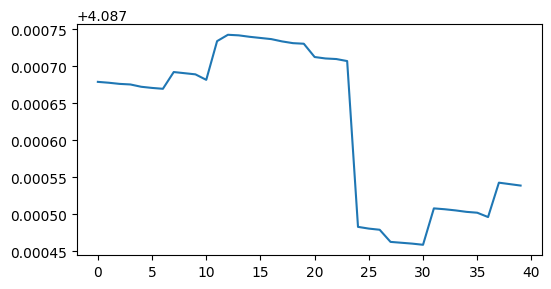

GLN Reward 35

53. Gravity: 50, Length: 2.5
Expert Reward: 999


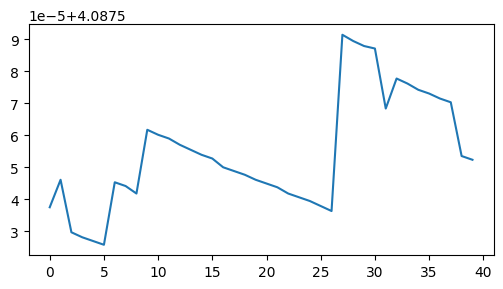

GLN Reward 53

54. Gravity: 130, Length: 4.5
Expert Reward: 31


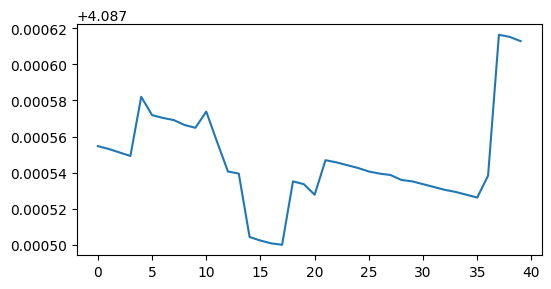

GLN Reward 51

55. Gravity: 50, Length: 1.0
Expert Reward: 999


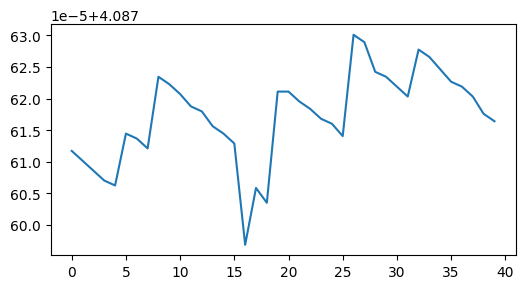

GLN Reward 61

56. Gravity: 90, Length: 4.0
Expert Reward: 59


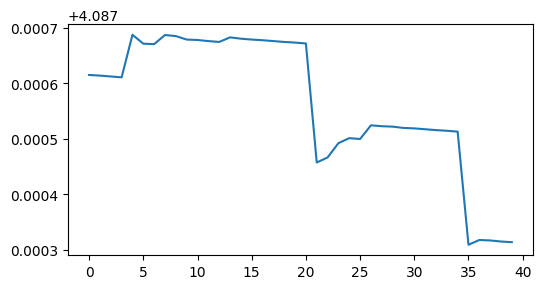

GLN Reward 52

57. Gravity: 10, Length: 0.5
Expert Reward: 999


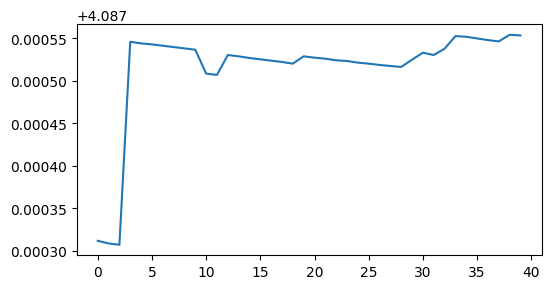

GLN Reward 207

58. Gravity: 130, Length: 0.5
Expert Reward: 255


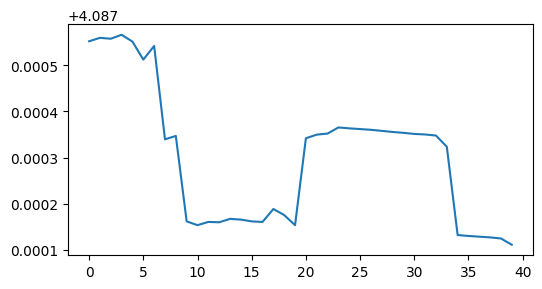

GLN Reward 18

59. Gravity: 10, Length: 3.5
Expert Reward: 98


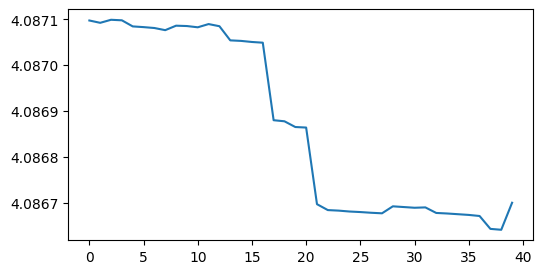

GLN Reward 176

60. Gravity: 130, Length: 1.5
Expert Reward: 999


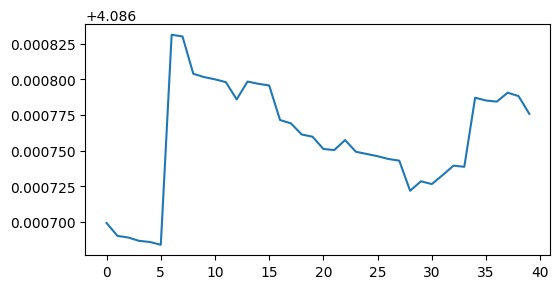

GLN Reward 37

61. Gravity: 130, Length: 4.0
Expert Reward: 33


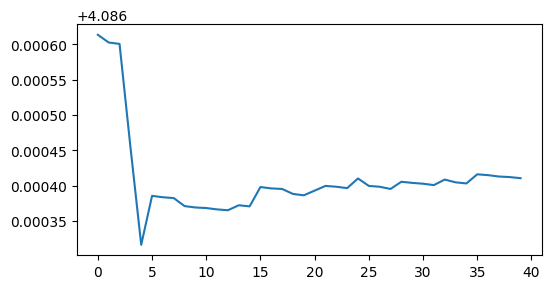

GLN Reward 51

62. Gravity: 90, Length: 3.0
Expert Reward: 49


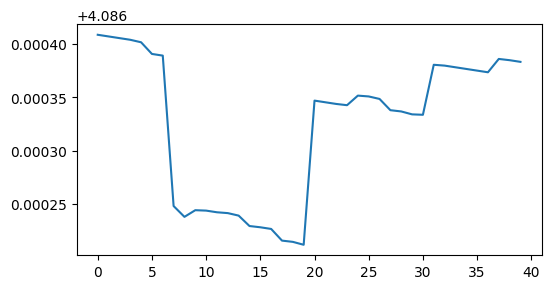

GLN Reward 41

63. Gravity: 170, Length: 2.5
Expert Reward: 31


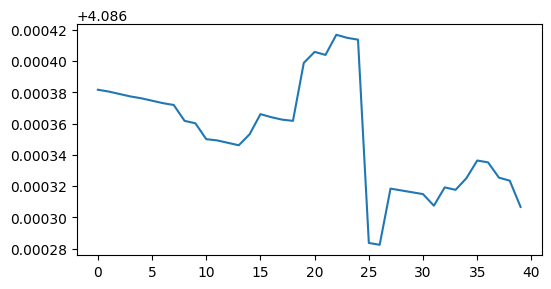

GLN Reward 43

64. Gravity: 50, Length: 3.5
Expert Reward: 77


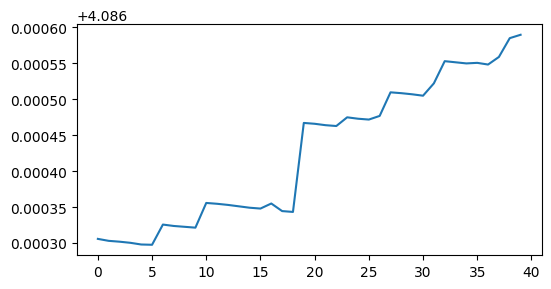

GLN Reward 113

65. Gravity: 110, Length: 1.0
Expert Reward: 999


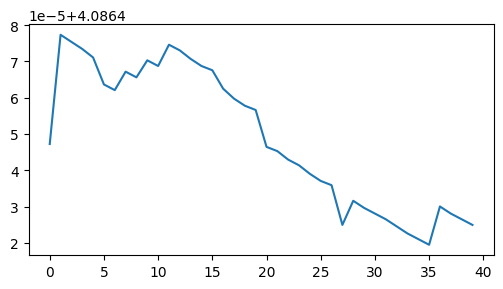

GLN Reward 21

66. Gravity: 90, Length: 5.0
Expert Reward: 35


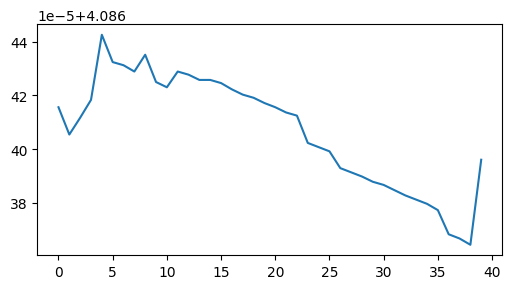

GLN Reward 46

67. Gravity: 190, Length: 1.0
Expert Reward: 27


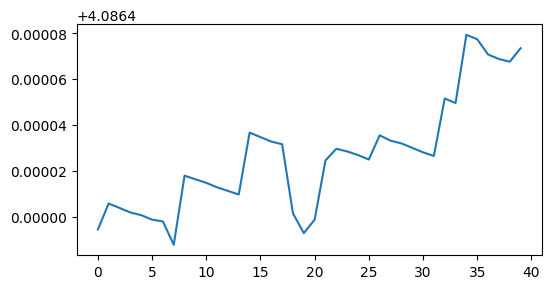

GLN Reward 39

68. Gravity: 190, Length: 1.5
Expert Reward: 999


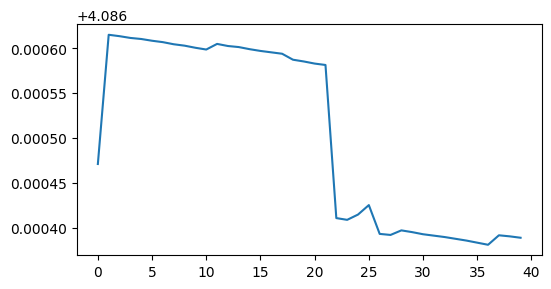

GLN Reward 23

69. Gravity: 190, Length: 5.0
Expert Reward: 28


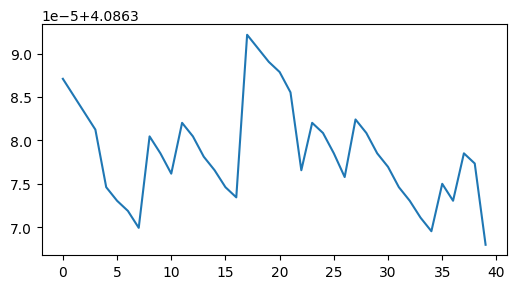

GLN Reward 35

70. Gravity: 90, Length: 0.5
Expert Reward: 999


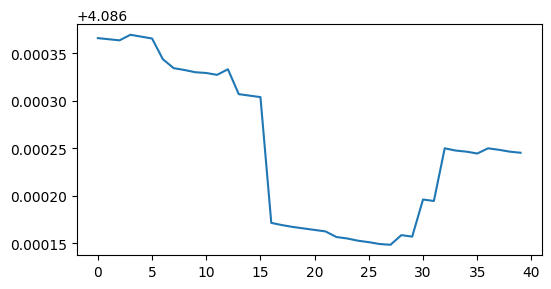

GLN Reward 24

71. Gravity: 130, Length: 1.0
Expert Reward: 999


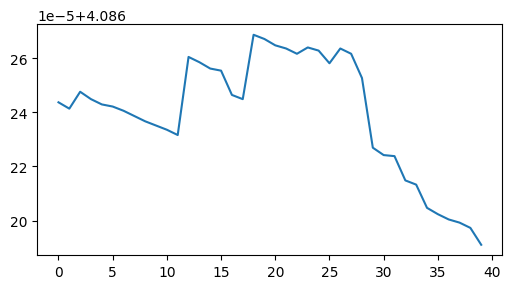

GLN Reward 41

72. Gravity: 30, Length: 1.5
Expert Reward: 999


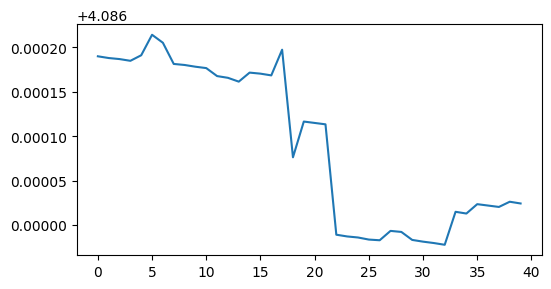

GLN Reward 86

73. Gravity: 70, Length: 1.5
Expert Reward: 999


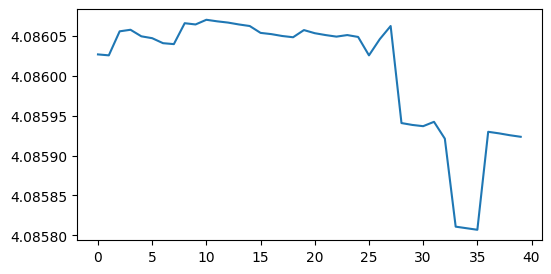

GLN Reward 48

74. Gravity: 190, Length: 3.5
Expert Reward: 36


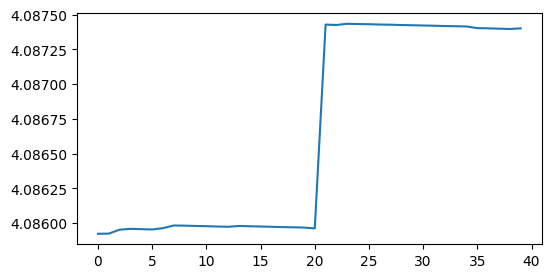

GLN Reward 29

75. Gravity: 90, Length: 3.5
Expert Reward: 38


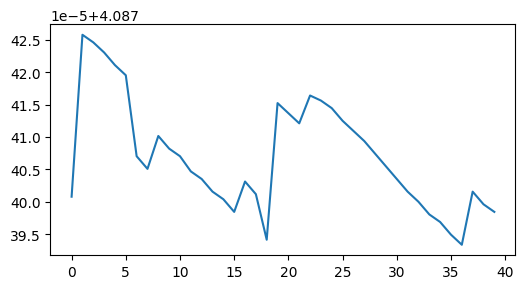

GLN Reward 81

76. Gravity: 110, Length: 4.5
Expert Reward: 31


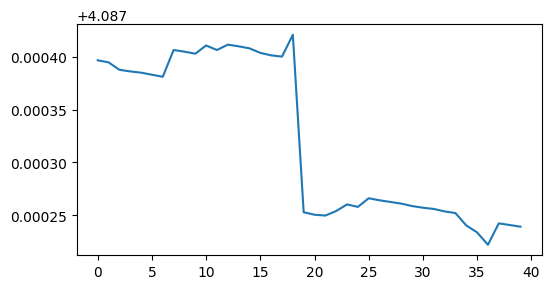

GLN Reward 43

77. Gravity: 30, Length: 2.5
Expert Reward: 999


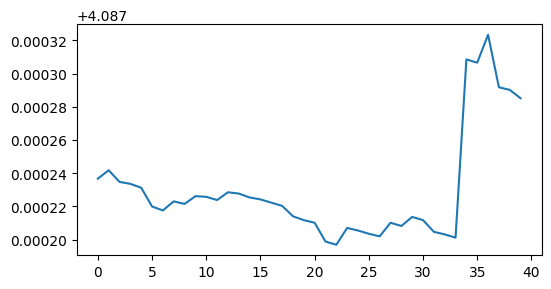

GLN Reward 64

78. Gravity: 150, Length: 2.0
Expert Reward: 29


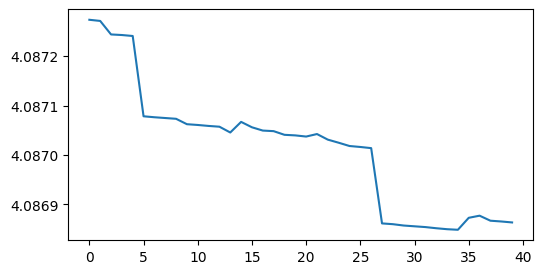

GLN Reward 26

79. Gravity: 70, Length: 4.5
Expert Reward: 33


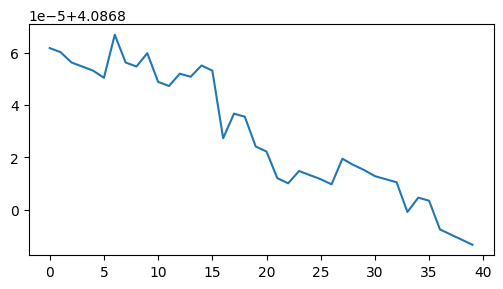

GLN Reward 79

80. Gravity: 170, Length: 4.5
Expert Reward: 29


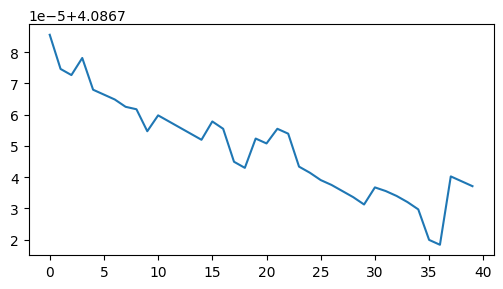

GLN Reward 81

81. Gravity: 70, Length: 1.0
Expert Reward: 999


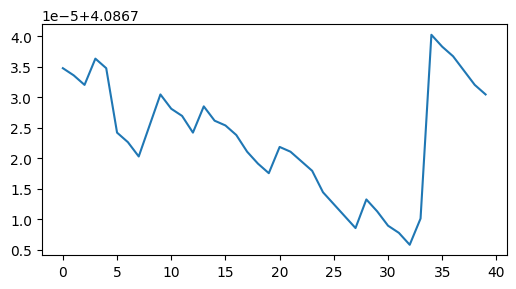

GLN Reward 43

82. Gravity: 170, Length: 5.0
Expert Reward: 28


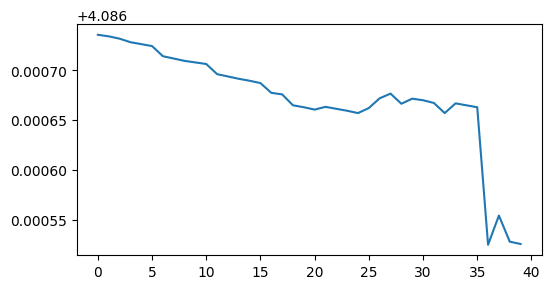

GLN Reward 37

83. Gravity: 90, Length: 4.5
Expert Reward: 32


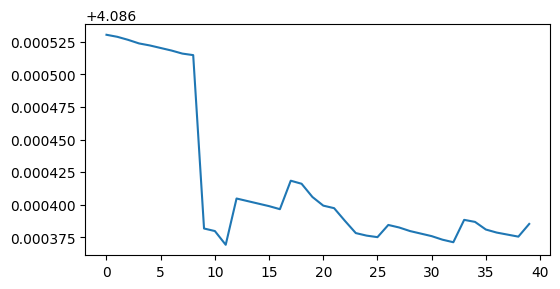

GLN Reward 56

84. Gravity: 150, Length: 4.0
Expert Reward: 46


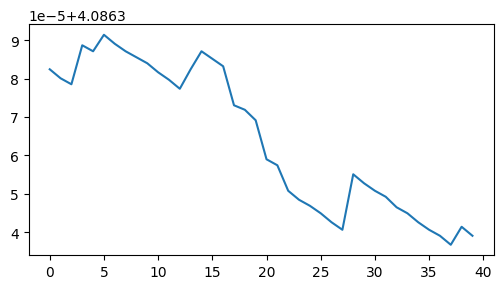

GLN Reward 105

85. Gravity: 150, Length: 3.5
Expert Reward: 33


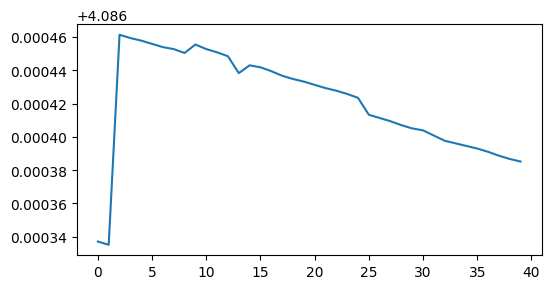

GLN Reward 59

86. Gravity: 10, Length: 4.0
Expert Reward: 104


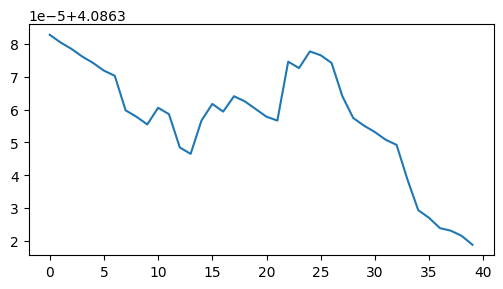

GLN Reward 118

87. Gravity: 130, Length: 2.0
Expert Reward: 999


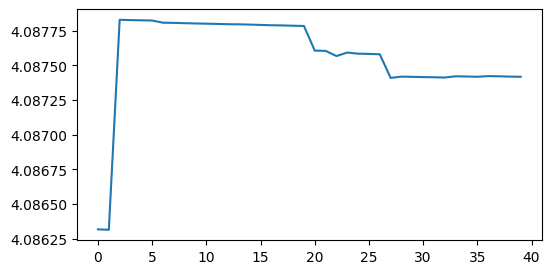

GLN Reward 25

88. Gravity: 130, Length: 5.0
Expert Reward: 31


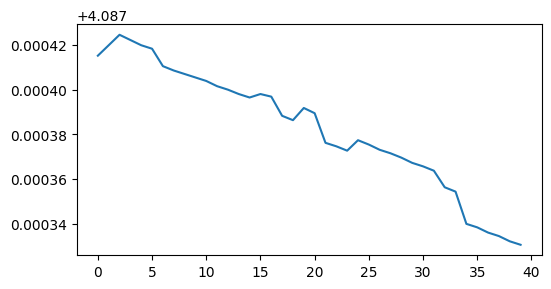

GLN Reward 43

89. Gravity: 150, Length: 4.5
Expert Reward: 33


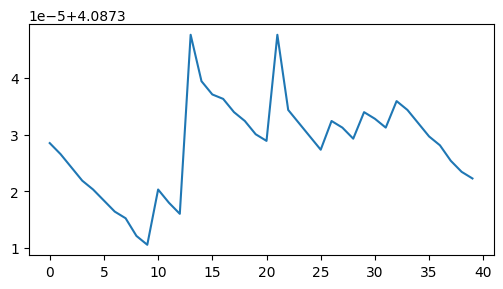

GLN Reward 37

90. Gravity: 110, Length: 5.0
Expert Reward: 34


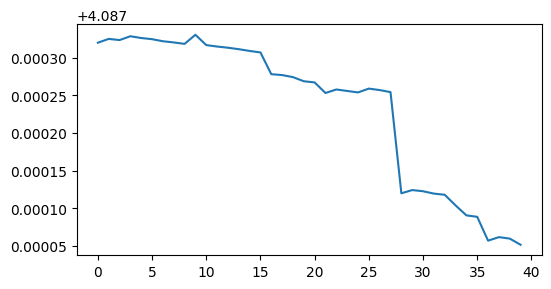

GLN Reward 34

91. Gravity: 110, Length: 2.5
Expert Reward: 999


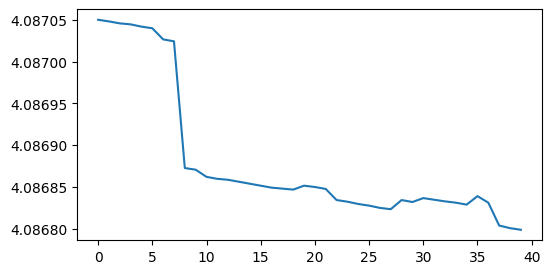

GLN Reward 43

92. Gravity: 50, Length: 5.0
Expert Reward: 38


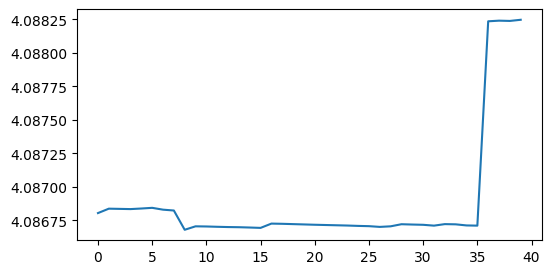

GLN Reward 90

93. Gravity: 90, Length: 1.0
Expert Reward: 999


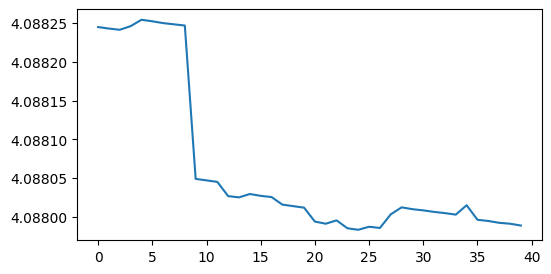

GLN Reward 30

94. Gravity: 110, Length: 3.5
Expert Reward: 51


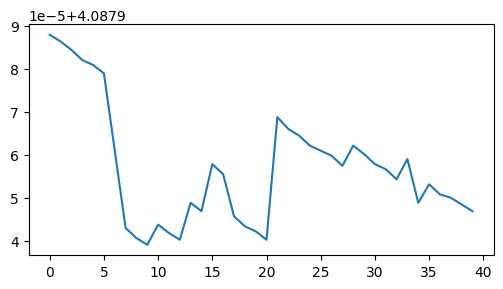

GLN Reward 57

95. Gravity: 70, Length: 2.0
Expert Reward: 999


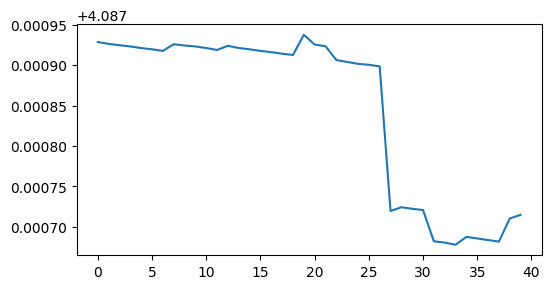

GLN Reward 52

96. Gravity: 150, Length: 5.0
Expert Reward: 30


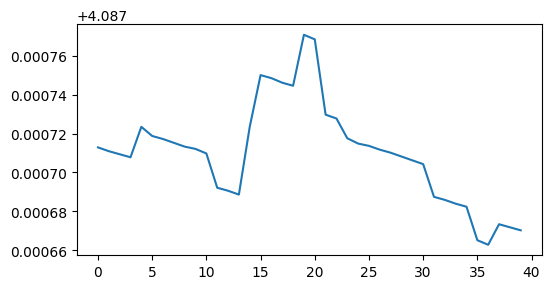

GLN Reward 82

97. Gravity: 190, Length: 3.0
Expert Reward: 37


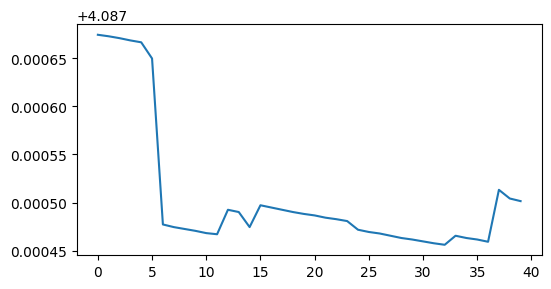

GLN Reward 28



In [271]:
print("Testing:")
i=1
for g,l in settings[3:]:
    print(f"{i}. Gravity: {g}, Length: {l}")
    env.length , env.gravity = l , g
    env.polemass_length = env.masspole * env.length
    GLN_perf[g][l] = GLN_adapt(env,expert,gln)
    print()
    i+=1

In [265]:
obs.shape

torch.Size([5000, 4])